# Машинное обучение в добыче золота: предсказание коэффициента восстановления золота из золотосодержащей руды

Компания «Цифры» разрабатывает решения для эффективной работы промышленных предприятий. Компании нужен прототип модели машинного обучения, которая будет предсказывать коэффициент восстановления золота из золотосодержащей руды. Такая модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

«Цифры» предоставили данные с параметрами добычи и очистки.

### Изучение технологического процесса 

Тема данной работы достаточно сложная, поэтому для понимания проекта необходимо разобраться в сути технологического процесса восстановления золота из руды.

Когда добытая руда проходит первичную обработку, получается дроблёная смесь. Её отправляют на флотацию (обогащение) и двухэтапную очистку.

1. Флотация
- Во флотационную установку подаётся смесь золотосодержащей руды. После обогащения получается черновой концентрат и «отвальные хвосты», то есть остатки продукта с низкой концентрацией ценных металлов.
На стабильность этого процесса влияет непостоянное и неоптимальное физико-химическое состояние флотационной пульпы (смеси твёрдых частиц и жидкости).
2. Очистка 
- Черновой концентрат проходит две очистки. На выходе получается финальный концентрат и новые отвальные хвосты.

### Метрика оценки качества модели

Для решения задачи воспользуемся метрикой sMAPE (Symmetric Mean Absolute Percentage Error) - симметричное среднее абсолютное процентное отклонение. Она одинаково учтет масштаб и целевого признака, и предсказания.

sMAPE будет рассчитана отдельно для:
- чернового концентрата: rougher.output.recovery
- итогового концентрата: final.output.recovery

Также введем метрику итогового sMAPE, который будет складываться из 25% sMAPE rougher и 75% sMAPE final.

## Подготовка данных

Импортируем необходимые библиотеки и зададим нужные опции.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import Pipeline

pd.set_option('display.max_columns', 100)
warnings.simplefilter('ignore')

Сохраним данные в датафреймы.

In [2]:
try:
    df_train = pd.read_csv('gold_recovery_train_new.csv')
    df_test = pd.read_csv('gold_recovery_test_new.csv')
    df_full = pd.read_csv('gold_recovery_full_new.csv')
    
except:
    df_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
    df_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
    df_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')

Данные состоят из файлов, полученных из разных источников:

- `gold_recovery_train_new.csv` — обучающая выборка;
- `gold_recovery_test_new.csv` — тестовая выборка (неполная);
- `gold_recovery_full_new.csv` — полные данные.

Наименование каждого столбца имеет следующую структуру:
- `[этап].[тип_параметра].[название_параметра]`
- например: `rougher.input.feed_ag`

Ознакомимся с ключами описания полей данных:
1. Этап
- `rougher` — флотация;
- `primary_cleaner` — первичная очистка;
- `secondary_cleaner` — вторичная очистка;
- `final` — финальные характеристики.

2. Тип параметра
- `input` — параметры сырья;
- `output` — параметры продукта;
- `state` — параметры, характеризующие текущее состояние этапа;
- `calculation` — расчётные характеристики.

3. Технологический процесс (ключи к параметрам)
- `Rougher feed` — исходное сырье;
- `Rougher additions (или reagent additions)` — флотационные реагенты: Xanthate, Sulphate, Depressant;
- `Xanthate` — ксантогенат (промотер, или активатор флотации);
- `Sulphate` — сульфат (на данном производстве сульфид натрия);
- `Depressant` — депрессант (силикат натрия);
- `Rougher process` — флотация;
- `Rougher tails` — отвальные хвосты;
- `Float banks` — флотационная установка;
- `Cleaner process` — очистка;
- `Rougher Au` — черновой концентрат золота;
- `Final Au` — финальный концентрат золота;
- `air amount` — объём воздуха;
- `fluid levels` — уровень жидкости;
- `feed size` — размер гранул сырья;
- `feed rate` — скорость подачи.

Выведем общую информацию о каждом датафрейме, а также его первые и последние 5 строк.

In [3]:
dfs = [df_train, df_test, df_full]
dfs_names = ['df_train', 'df_test', 'df_full']

for df, df_name in zip(dfs, dfs_names):
    print(df_name)
    print()
    print(df.info())
    display(df)

df_train

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

df_test

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  pri

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289,1250.493702,-399.746728,1199.398691,-397.50

df_full

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null 

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

Исходя из задания (описания расчета sMAPE), **целевыми признаками являются rougher.output.recovery и final.output.recovery**.

### Проверка правильности расчета эффективности обогащения

Проверим правильность расчета эффективности обогащения. 

Вычислим ее на обучающей выборке для признака rougher.output.recovery. 

Формула расчета эффективности обогащения:

~~~
(rougher.output.concentrate_au * (rougher.input.feed_au - rougher.output.tail_au) * 100) /
rougher.input.feed_au * (rougher.output.concentrate_au - rougher.output.tail_au)

~~~

In [4]:
rougher_output_recovery_calculated = (
    (
    df_train['rougher.output.concentrate_au'] * (
    df_train['rougher.input.feed_au'] - df_train['rougher.output.tail_au']
    )
    ) / (
    df_train['rougher.input.feed_au'] * (
    df_train['rougher.output.concentrate_au'] - df_train['rougher.output.tail_au']
    )
    ) * 100
).head()

print('Исходные значения эффективности обогащения')
print()
print(df_train['rougher.output.recovery'].head())
print()
print()
print('Рассчитанные значения эффективности обогащения')
print()
print(rougher_output_recovery_calculated)

Исходные значения эффективности обогащения

0    87.107763
1    86.843261
2    86.842308
3    87.226430
4    86.688794
Name: rougher.output.recovery, dtype: float64


Рассчитанные значения эффективности обогащения

0    87.107763
1    86.843261
2    86.842308
3    87.226430
4    86.688794
dtype: float64


Найдем значение MAE между исходными и рассчитанными значениями признака.

In [5]:
print(
    'Значение среднего абсолютного отклонения:', 
     mean_absolute_error(df_train['rougher.output.recovery'].head(),
                          rougher_output_recovery_calculated)
     )

Значение среднего абсолютного отклонения: 5.684341886080802e-15


**Значение среднего абсолютного отклонения крайне мало. Это говорит о том, что данные рассчитаны верно**.

### Анализ отсутствующих в тестовой выборке данных

Выведем список столбцов с данными, которые есть в обучающей выборке, но отсутствуют в тестовой.

In [6]:
test_missed_cols = []

for col in df_train.columns:
    if col not in df_test.columns:
        test_missed_cols.append(col)
        
test_missed_cols

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

**В тестовой выборке полностью отсутствуют выходные данные**: доля содержания металлов / примесей в руде перед каждым этапом, эффективность обогащения, а также все калькуляции.

## Предобработка данных

### Изменение индексации

Установим в качестве индекса Для каждого датафрейма столбец date.

Перед этим необходимо проверить каждый столбец date на наличие дубликатов, а также изменить формат столбца на datetime.

In [7]:
for df, df_name in zip(dfs, dfs_names):
    duplicates_num = df['date'].duplicated().sum()
    
    print(f'Количество дубликатов в столбце date датафрейма {df_name}: {duplicates_num}')

Количество дубликатов в столбце date датафрейма df_train: 0
Количество дубликатов в столбце date датафрейма df_test: 0
Количество дубликатов в столбце date датафрейма df_full: 0


In [8]:
def indexer(data):
    data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d %H:%M:%S')
    data = data.set_index('date')
    return data

In [9]:
df_train = indexer(df_train)
df_test = indexer(df_test)
df_full = indexer(df_full)

### Обработка пропусков

Для каждого датафрейма выведем пару "столбец-количество пропусков" по убыванию числа пропусков.

In [10]:
dfs = [df_train, df_test, df_full]

for df, df_name in zip(dfs, dfs_names):
    print(df_name)
    print()

    gap_ser = df.isna().sum().sort_values(ascending=False)
    
    print(f'Общее количество пропусков в датафрейме: {gap_ser[gap_ser > 1].sum()}')
    print(f'Общее число столбцов с пропусками: {gap_ser[gap_ser > 1].count()}')
    
    display(gap_ser[gap_ser > 1])
    print()
    print()

df_train

Общее количество пропусков в датафрейме: 4070
Общее число столбцов с пропусками: 32


secondary_cleaner.output.tail_sol           1605
rougher.state.floatbank10_e_air              436
rougher.input.floatbank11_xanthate           428
primary_cleaner.output.concentrate_sol       286
secondary_cleaner.state.floatbank2_a_air     217
final.output.concentrate_sol                 211
rougher.input.feed_size                      144
rougher.input.feed_pb                        100
final.output.tail_pb                         100
primary_cleaner.input.xanthate               100
primary_cleaner.output.concentrate_pb         86
rougher.input.feed_sol                        78
primary_cleaner.output.tail_sol               46
rougher.input.floatbank11_sulfate             36
primary_cleaner.input.depressant              32
rougher.input.floatbank10_sulfate             29
rougher.output.concentrate_sol                22
secondary_cleaner.state.floatbank2_b_air      21
primary_cleaner.input.sulfate                 20
primary_cleaner.output.tail_pb                15
secondary_cleaner.ou



df_test

Общее количество пропусков в датафрейме: 89
Общее число столбцов с пропусками: 11


rougher.input.floatbank11_xanthate          25
rougher.input.feed_sol                      21
secondary_cleaner.state.floatbank3_a_air     9
rougher.input.floatbank11_sulfate            8
primary_cleaner.input.depressant             5
rougher.input.floatbank10_sulfate            5
primary_cleaner.input.sulfate                4
primary_cleaner.input.xanthate               4
rougher.input.feed_rate                      3
secondary_cleaner.state.floatbank2_a_air     3
secondary_cleaner.state.floatbank2_b_air     2
dtype: int64



df_full

Общее количество пропусков в датафрейме: 4454
Общее число столбцов с пропусками: 36


secondary_cleaner.output.tail_sol                     1748
rougher.input.floatbank11_xanthate                     453
rougher.state.floatbank10_e_air                        436
primary_cleaner.output.concentrate_sol                 370
secondary_cleaner.state.floatbank2_a_air               220
final.output.concentrate_sol                           211
rougher.input.feed_size                                145
primary_cleaner.output.concentrate_pb                  116
primary_cleaner.input.xanthate                         104
final.output.tail_pb                                   101
rougher.input.feed_pb                                  100
rougher.input.feed_sol                                  99
primary_cleaner.output.tail_sol                         62
rougher.input.floatbank11_sulfate                       44
primary_cleaner.input.depressant                        37
rougher.input.floatbank10_sulfate                       34
primary_cleaner.input.sulfate                           

В данных очень много пропусков и столбцов с пропусками, особенно в датафрейме с обучающей выборкой. Тем не менее, среди столбцов с наибольшим числом пропусков отсутствуют оные с целевыми признаками.

Выведем абсолютное число пропусков для каждого целевого столбца.

In [11]:
for df, df_name in zip([df_train, df_full], ['df_train', 'df_full']):
    first_target_gaps = df['rougher.output.recovery'].isna().sum()
    second_target_gaps = df['final.output.recovery'].isna().sum()
    
    print(f'Датафрейм {df_name}')
    print(f'Количество пропусков в целевом столбце rougher.output.recovery: {first_target_gaps}')
    print(f'Количество пропусков в целевом столбце final.output.recovery: {second_target_gaps}')
    print()

Датафрейм df_train
Количество пропусков в целевом столбце rougher.output.recovery: 0
Количество пропусков в целевом столбце final.output.recovery: 0

Датафрейм df_full
Количество пропусков в целевом столбце rougher.output.recovery: 0
Количество пропусков в целевом столбце final.output.recovery: 0



Т.к. в столбцах с целевыми признаками нет пропусков, мы можем заполнить все пропуски ближайшими значениями по индексации, т.к. в задании указано, что соседние по времени параметры зачастую схожи.

In [12]:
df_train = df_train.fillna(method='ffill')
df_test = df_test.fillna(method='ffill')
df_full = df_full.fillna(method='ffill')

### Обработка дубликатов

Проверим каждый датафрейм на наличие явных дубликатов.

In [13]:
for df, df_name in zip(dfs, dfs_names):
    print(f'Количество явных дубликатов в датафрейме {df_name}: {df.duplicated().sum()}')

Количество явных дубликатов в датафрейме df_train: 0
Количество явных дубликатов в датафрейме df_test: 0
Количество явных дубликатов в датафрейме df_full: 0


**Ни в одном датафрейме нет явных дубликатов**.

Также можно уверенно сказать, что **неявных дубликатов в датафреймах также нет**, т.к.:
- датафреймы имеют в качестве индексов данные типа datetime;
- среди индексов датафреймов дубликаты отсутствуют.

## Анализ данных

### Анализ изменения концентрации металлов на различных этапах очистки

Для каждого металла выведем гистограммы, отражающие содержание металла на каждом этапе очистки.

In [14]:
# создадим списки с названиями столбцов с концентрациями
# для каждого металла

stages_to_plot_au = []
stages_to_plot_ag = []
stages_to_plot_pb = []

for stage in ['rougher.input.feed_', 'rougher.output.concentrate_', 
               'primary_cleaner.output.concentrate_', 'final.output.concentrate_']:
    
    stages_to_plot_au.append(f'{stage}au')
    stages_to_plot_ag.append(f'{stage}ag')
    stages_to_plot_pb.append(f'{stage}pb')

In [15]:
# создадим функцию, которая вернет по 4 гистограммы 
# с содержанием каждого металла на каждом этапе

def plot_metals(df, metal):
    
    fig, ax = plt.subplots()
    columns = df.columns
    
    for col in columns:
        sns.distplot(a=df[col], label=col)
        ax.set_xlabel(metal)
        ax.set_ylabel('')
        ax.legend()
    fig.show()

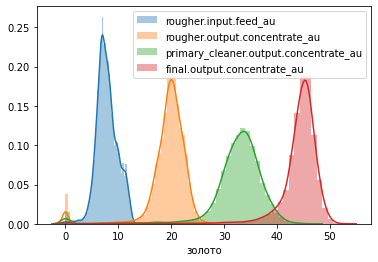

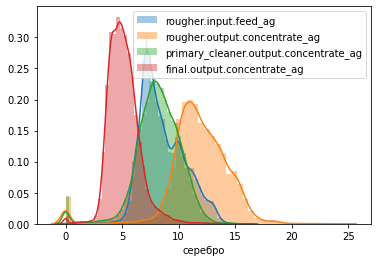

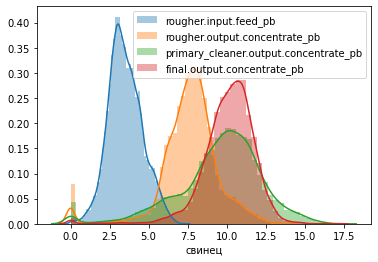

In [16]:
# выведем графики

plot_metals(df_train[stages_to_plot_au], 'золотo')
plot_metals(df_train[stages_to_plot_ag], 'серебро')
plot_metals(df_train[stages_to_plot_pb], 'свинец')

Из графиков можно сделать следующие выводы:
- **содержание золота** по ходу процесса очистки - от флотации до финальной стадии - **равномерно растет**, что логично, т.к. сам процесс добычи золота подразумевает уменьшение в сырье долей примесей, и, тем самым, "превращение" исходного материала в золото. При этом мода значений содержания металла до флотации - около 7 %, в конце обработки - около 45 %;
- **содержание серебра после флотации растет (мода примерно на 4 %), однако затем равномерно падает (мода от 11 % до 4 %)**. На своем уровне понимания технологии добычи я не могу объяснить, с чем это связано;
- **содержание свинца растет**, притом после флотации более резко, после очистки - более полого. **Мода значений содержания свинца достигает 11 %**.

Общий вывод: с учетом того, что сам процесс обработки сырья подразумевает добычу золота, т.е. увеличение количества его содержания, **с данными все корректно и процесс происходит правильно**.

### Анализ распределения размеров гранул сырья

Построим графики (ящики с усами) распределения размеров гранул сырья для обучающей и тестовой выборки.

В датафреймах представлены два столбца, содержащие информацию о размере гранул: 


|rougher.input.feed_size|перед флотацией| 
|-|-|
|primary_cleaner.input.feed_size|после флотации|

Сначала проведем анализ распределенения размера гранул сырья перед флотацией.

#### Анализ распределения размеров гранул сырья перед флотацией

Построим боксплоты для сравнения распределенения размера гранул сырья перед флотацией.

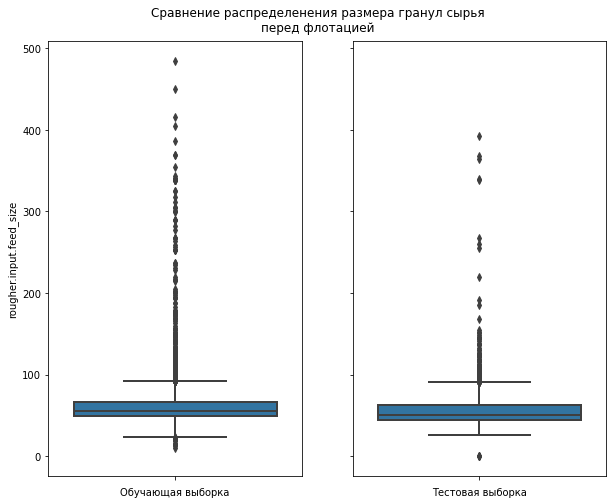

In [17]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10,8))

sns.boxplot(y='rougher.input.feed_size', linewidth=2, data=df_train, ax=ax[0])
ax[0].set_xlabel('Обучающая выборка')

sns.boxplot(y='rougher.input.feed_size', linewidth=2, data=df_test, ax=ax[1])
ax[1].set_xlabel('Tестовая выборка')
ax[1].set_ylabel('')

plt.suptitle('''Сравнение распределенения размера гранул сырья
перед флотацией''', y=0.94);

**Построим аналогичные графики без учета выбросов**.

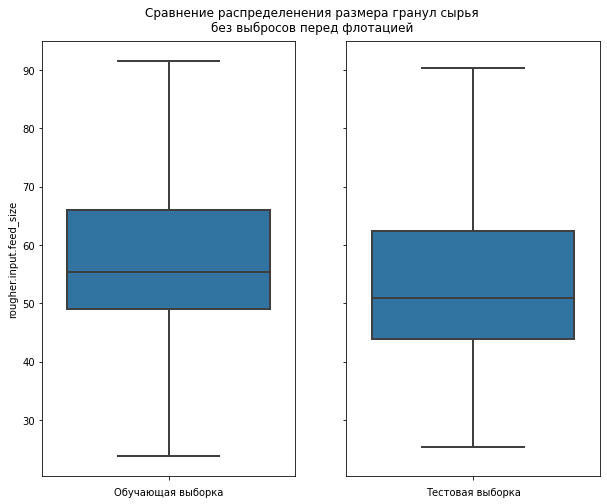

In [18]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10,8))

sns.boxplot(y='rougher.input.feed_size', linewidth=2, data=df_train, ax=ax[0], showfliers=False)
ax[0].set_xlabel('Обучающая выборка')


sns.boxplot(y='rougher.input.feed_size', linewidth=2, data=df_test, ax=ax[1], showfliers=False)
ax[1].set_xlabel('Tестовая выборка')
ax[1].set_ylabel('')

plt.suptitle('''Сравнение распределенения размера гранул сырья
без выбросов перед флотацией''', y=0.94);

Оба средних значения - для данных из обучающей выборки и из тестовой - расположены близко друг к другу и каждое из них находятся в диапазоне между первым и третьим квартилем каждой выборки. 

Усы каждого ящика расположены еще ближе друг к другу, чем средние значения. Объем выбросов в обучающей выборке больше, но характер их распределения схож с оным в тестовой выборке.

С учетом этого **принимаем, что распределение размеров гранул сырья перед флотацией в целом равномерное**, т.е. не исказит результаты исследования.

#### Анализ распределения размеров гранул сырья после флотации

Построим боксплоты для сравнения распределенения размера гранул сырья после флотации.

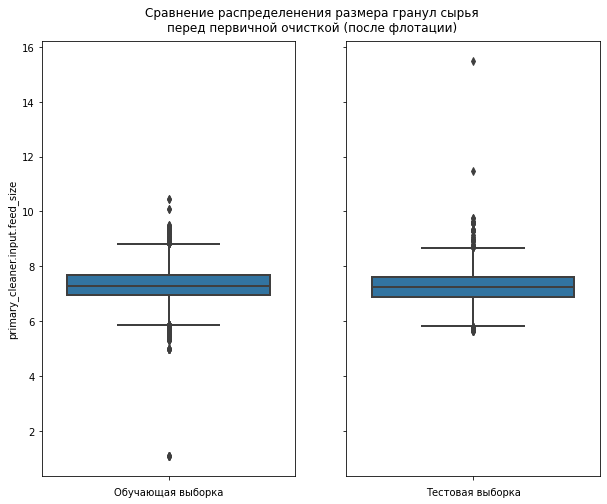

In [19]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10,8))

sns.boxplot(y='primary_cleaner.input.feed_size', linewidth=2, data=df_train, ax=ax[0])
ax[0].set_xlabel('Обучающая выборка')

sns.boxplot(y='primary_cleaner.input.feed_size', linewidth=2, data=df_test, ax=ax[1])
ax[1].set_xlabel('Tестовая выборка')
ax[1].set_ylabel('')

plt.suptitle('''Сравнение распределенения размера гранул сырья
перед первичной очисткой (после флотации)''', y=0.94);

**Построим аналогичные графики без учета выбросов**.

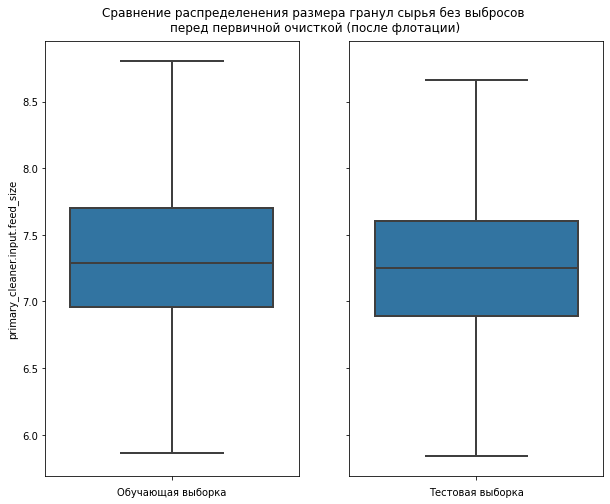

In [20]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10,8))

sns.boxplot(y='primary_cleaner.input.feed_size', linewidth=2, data=df_train, ax=ax[0], showfliers=False)
ax[0].set_xlabel('Обучающая выборка')

sns.boxplot(y='primary_cleaner.input.feed_size', linewidth=2, data=df_test, ax=ax[1], showfliers=False)
ax[1].set_xlabel('Tестовая выборка')
ax[1].set_ylabel('')

plt.suptitle('''Сравнение распределенения размера гранул сырья без выбросов 
перед первичной очисткой (после флотации)''', y=0.94);

В целом ситуация с распределением размера гранул сырья после флотации схожа с оной перед флотацией, однако есть и отличия.

Оба средних значения расположены значительно ближе друг к другу, чем до флотации. Каждое из них также находятся в диапазоне между первым и третьим квартилем каждой выборки.

Усы каждого ящика расположены достаточно близко друг к другу, но притом дальше, чем до флотации. Объем выбросов в обучающей выборке также больше, но характер их распределения схож с оным в тестовой выборке.

Таким образом, **распределение размеров гранул сырья после флотации принимаем равномерным**.

Однако построим также график изменения размеров гранул сырья, чтобы иметь более общую картину.

#### Анализ изменения размеров гранул сырья перед флотацией и после нее

In [21]:
# создадим функцию, которая вернет списков списков с медианными значениями
# размера гранул сырья после каждого этапа

def size_func(df_1, df_2):
    return [
        [
        df_1['rougher.input.feed_size'].median(),
        df_1['primary_cleaner.input.feed_size'].median()
        ],
        [
        df_2['rougher.input.feed_size'].median(),
        df_2['primary_cleaner.input.feed_size'].median()
        ]
    ]

In [22]:
# сохраним список списков

size_list = size_func(df_train, df_test)

Построим график для каждого подсписка, при этом зададим индексацию в соответствии с этапом.

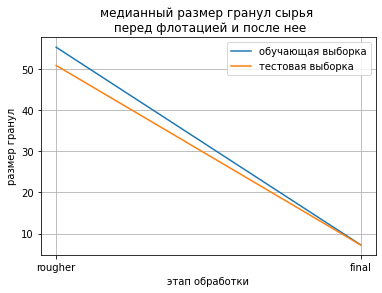

In [23]:
plt.title('медианный размер гранул сырья \n перед флотацией и после нее')

for i in range(2):
    size_list[i] = pd.DataFrame(size_list[i])
    size_list[i].index = ['rougher', 'final']
    plt.plot(size_list[i]);

plt.legend(['обучающая выборка',
            'тестовая выборка'])

plt.xlabel('этап обработки', fontsize=10)
plt.ylabel('размер гранул', fontsize=10)

plt.grid()

Данный график, как и боксплоты, показывает более серьезное различие размеров гранул сырья перед флотацией, чем после нее. В целом график подтвердил предыдущие выводы.

### Анализ суммарной концентрации всех веществ на разных стадиях

Проведем анализ на основе данных из обучающей выборки.

Выведем список названий столбцов с данными о концентрации.

In [24]:
concentrate_cols = [col for col in df_train.columns if ('output' in col) & ('recovery' not in col)]

concentrate_cols

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.tail_sol',
 'rougher.output.tail_au',
 'secondary_cleaner.output.tail_ag',
 'secondary_cleaner.output.tail_pb',
 'secondary_cleaner.output.tail_sol',
 'secondary_cleaner.output.tail_au']

Для каждого этапа создадим свои списки с названиями столбцов, которые затем передадим другому списку.

In [25]:
concentrate_rougher_cols = [col for col in concentrate_cols if 'rougher' in col]
concentrate_primary_cleaner_cols = [col for col in concentrate_cols if 'primary_cleaner' in col]
concentrate_final_cols = [col for col in concentrate_cols if 'final' in col]

concentrate_stages_cols = [concentrate_rougher_cols, concentrate_primary_cleaner_cols, concentrate_final_cols]

In [26]:
# создадим функцию, которая вернет гистограмму
# с суммарным содержанием всех веществ на каждом этапе

def plot_agents(df, metal):
    
    fig, ax = plt.subplots()
    
    for col, stage_name in zip(concentrate_stages_cols, ['rougher', 'primary cleaner', 'final']):
        sns.distplot(a=df[col].sum(axis=1), label=stage_name)
        ax.set_xlabel(metal)
        ax.set_ylabel('')
        ax.legend()
    fig.show()

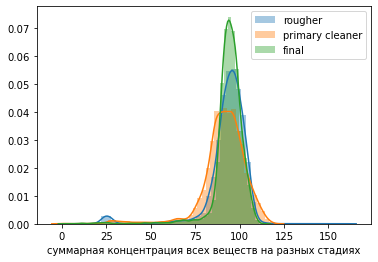

In [27]:
# выведем график

plot_agents(df_train, 'суммарная концентрация всех веществ на разных стадиях')

Каких-либо наблюдений, которые говорили бы о некорректности данных, не замечено. 

## Подготовка данных к машинному обучение

### Обработка тестового датафрейма

Удалим из обучающего датафрейма все фичи, которых нет в тестовом.

In [28]:
target_cols = ['rougher.output.recovery', 'final.output.recovery']
 
cols_to_drop = [col for col in test_missed_cols if col not in target_cols]

df_train = df_train.drop(columns=cols_to_drop)

Осталось добавить в тестовый датафрейм столбцы с целевыми признаками из полного датафрейма.

In [29]:
df_test = df_test.join(df_full['rougher.output.recovery'])
df_test = df_test.join(df_full['final.output.recovery'])

Проверим, ровно ли количество столбцов в каждом из двух датафреймов

In [30]:
df_train.shape[1] == df_test.shape[1]

True

Также проверим правильность присоединения столбцов.

In [31]:
(
    df_test.iloc[-1]['rougher.output.recovery'] == 
    df_full.iloc[-1]['rougher.output.recovery']
)

False

In [32]:
(
    df_test.loc['2017-12-31 19:59:59']['rougher.output.recovery'] == 
    df_full.loc['2017-12-31 19:59:59']['rougher.output.recovery']
)

True

Столбцы присоединены правильно.

Проверим количество пропусков в обновленном датафрейме.

In [33]:
df_test.isna().sum()

primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate            0
rougher.input.floatbank11_sulfate       

Пропусков нет.

### Удаление неинформативных данных

Сбросим индексы датафреймов, т.к. эти данные - date - не являются информативными и не нужны для дальнейшей работы.

In [34]:
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

### Написание целевых формул

Напишем функции для расчета sMAPE и итогового sMAPE.

In [35]:
def smape(y, pred):
    return (1 / len(y)) * np.sum(np.abs(pred - y) / ((np.abs(y) + np.abs(pred)) / 2)) * 100

def smape_total(smape_rough, smape_final):
    smape_total = smape_rough*0.25 + smape_final*0.75
    return smape_total

### Разбиение данных на выборки

In [36]:
X_train = df_train.drop(columns=['final.output.recovery', 'rougher.output.recovery'])
X_test = df_test.drop(columns=['final.output.recovery', 'rougher.output.recovery'])


y_train_rougher, y_train_cleaner = df_train['rougher.output.recovery'], df_train['final.output.recovery']
y_test_rougher, y_test_cleaner = df_test['rougher.output.recovery'], df_test['final.output.recovery']

### Масштабирование данных

In [37]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Машинное обучение

Обучим модели:
- DecisionTreeRegressor
- RandomForestRegressor
- LinearRegression

Для удобства проведем машинное обучение с пайплайном - таким образом мы сразу определим, какая модель имеет наибольшее значение ключевой метрики - sMAPE.

In [38]:
%%time

pipeline = Pipeline([('model', RandomForestRegressor(random_state=12345))])

params_grid = [{'model': [DecisionTreeRegressor(random_state=12345)],
                'model__max_depth': [2, 4, 6]},
               {'model': [RandomForestRegressor(random_state=12345)],
                'model__max_depth': [2, 4, 6],
                'model__n_estimators': [20, 40, 60],},  
               {'model': [LinearRegression()]}]

gridSearch = GridSearchCV(estimator=pipeline, 
                          param_grid=params_grid, 
                          cv=KFold(), 
                          scoring=make_scorer(smape, greater_is_better=False),
                          n_jobs=-1
                          )

gridSearch.fit(X_train, y_train_rougher)

CPU times: total: 4.7 s
Wall time: 1min 18s


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('model',
                                        RandomForestRegressor(random_state=12345))]),
             n_jobs=-1,
             param_grid=[{'model': [DecisionTreeRegressor(random_state=12345)],
                          'model__max_depth': [2, 4, 6]},
                         {'model': [RandomForestRegressor(max_depth=6,
                                                          n_estimators=20,
                                                          random_state=12345)],
                          'model__max_depth': [2, 4, 6],
                          'model__n_estimators': [20, 40, 60]},
                         {'model': [LinearRegression()]}],
             scoring=make_scorer(smape, greater_is_better=False))

Выведем параметры лучшей модели.

In [39]:
display(gridSearch.best_estimator_)
display(gridSearch.best_params_)
display(gridSearch.best_score_)

Pipeline(steps=[('model',
                 RandomForestRegressor(max_depth=6, n_estimators=20,
                                       random_state=12345))])

{'model': RandomForestRegressor(max_depth=6, n_estimators=20, random_state=12345),
 'model__max_depth': 6,
 'model__n_estimators': 20}

-10.915564715983024

Лучшей моделью оказался случайный лес с количеством деревьев 20 и их глубиной, равной 6.

## Проверка модели на тестовой выборке

Рассчитаем sMAPE на тестовой выборке.

In [40]:
model = RandomForestRegressor(max_depth=6, n_estimators=20, random_state=12345).fit(X_train, y_train_rougher)
predict_rougher = model.predict(X_test)
print('Значение sMAPE rougher:', smape(y_test_rougher, predict_rougher))


model = RandomForestRegressor(max_depth=6, n_estimators=20, random_state=12345).fit(X_train, y_train_cleaner)
predict_cleaner = model.predict(X_test)
print('Значение sMAPE cleaner:', smape(y_test_cleaner, predict_cleaner))
print()
print('Итоговое sMAPE:', smape_total(smape(y_test_rougher, predict_rougher), smape(y_test_cleaner, predict_cleaner)))

Значение sMAPE rougher: 10.366582619823275
Значение sMAPE cleaner: 10.80131595919048

Итоговое sMAPE: 10.69263262434868


## Общий вывод

На основе входных данных по восстановлению золота из руды с параметрами добычи и очистки были проведены ряд исследовательских анализов и обучены модели машинного обучения. Цель: построение модели для предсказания коэффициента восстановления золота из золотосодержащей руды. Такая модель в будущем поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

В ходе работы были открыты и изучены файлы с данными, определены целевые признаки: rougher.output.recovery и final.output.recovery.

Далее была произведена **проверка правильности расчета эффективности обогащения**. Для целевого признака rougher.output.recovery были выведены исходные данные и рассчитанные по формуле. Значение среднего абсолютного отклонения оказалось крайне мало: 5.684341886080802e-15. Следовательно, данные рассчитаны верно.

Затем был произведен **анализ отсутствующих в тестовой выборке данных**. В ходе анализа выяснилось, что в тестовой выборке полностью отсутствуют выходные данные: доля содержания металлов / примесей в руде перед каждым этапом, эффективность обогащения, а также все калькуляции.

После **предобработки данных** был произведен **анализ изменения концентрации металлов на различных этапах очистки**. Анализ показал следующее:

- содержание золота по ходу процесса очистки равномерно растет, при этом мода значений содержания металла до флотации - около 7 %, а в конце обработки - около 45 %;
- содержание серебра после флотации растет, однако затем равномерно падает;
- содержание свинца растет, притом после флотации более резко, после очистки - более полого.

Общий вывод по анализу: с учетом того, что сам процесс обработки сырья подразумевает добычу золота, т.е. увеличение количества его содержания, с данными все корректно и процесс происходит правильно.

**Анализ распределения размеров гранул сырья** показал, что распределение равномерно: как перед флотацией, так и после нее.

В ходе **анализа суммарной концентрации всех веществ на разных стадиях** каких-либо наблюдений, которые говорили бы о некорректности данных, замечено не было.

Далее была произведена **подготовка данных для машинного обучения**, после - **машинное обучение** моделей
- DecisionTreeRegressor
- RandomForestRegressor
- LinearRegression

По результатам проверки лучшей моделью оказалась модель Random Forest с наименьшим значением sMAPE - симметричного среднего абсолютного процентного отклонения.

Последний этап - **проверка лучшей модели на тестовой выборке - расчет итогового sMAPE**, который оказался ранвым 10.69. Таким образом модель подходит для выполнения поставленных задач.

**Рекомендации**: для решения задачи предсказания рекомендую заказчику воспользоваться наилучшей моделью, а именно RandomForestRegressor со следующими параметрами:
- 'max_depth': 6
- 'n_estimators': 20

Таким образом, при значении итогового sMAPE 10.69 на тестовой выборке, заказчик сможет достаточно точно определять коэффициент восстановления золота из золотосодержащей руды, что поможет ему понять, какие предприятия потенциально убыточные. 